In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)

In [51]:
#data này đã drop_duplicate
df = pd.read_csv("/Users/phongminh/DS105/process/form_data.csv")

In [52]:
df = df.drop(columns=[df.columns[0]])

In [53]:
filtered_df = df[df['Mức giá'].str.contains('/m²', case=False, na=False)]
filtered_df

,Địa chỉ,Mức giá,Giá/m²,Số phòng ngủ,Huyện,Diện tích,Mặt tiền,Đường vào,Hướng nhà,Hướng ban công,Số tầng,Số toilet,Nội thất,Latitude,Longitude
99,"The Global City, An Phú, Quận 2, Hồ Chí Minh",119 triệu/m²,"~5,95 tỷ",1 phòng,Quận 2,50 m²,NaN,NaN,NaN,NaN,NaN,1 phòng,NaN,10.798775,106.756877
162,"Dự án Homyland Riverside, Đường Nguyễn Duy Tri...",40 triệu/m²,~3 tỷ,2 phòng,Quận 2,75 m²,NaN,NaN,NaN,NaN,NaN,2 phòng,NaN,10.789671,106.768532
164,"Dự án Lavida Plus, Đường Nguyễn Văn Linh, Phườ...",50 triệu/m²,"~1,85 tỷ",NaN,Quận 7,37 m²,NaN,NaN,NaN,NaN,NaN,NaN,Cơ bản,10.727764,106.701454
177,"Dự án Homyland Riverside, Đường Nguyễn Duy Tri...",45 triệu/m²,"~3,64 tỷ",2 phòng,Quận 2,81 m²,NaN,NaN,Đông - Nam,Tây - Bắc,NaN,2 phòng,Cơ bản,10.789671,106.768532
273,"Dự án Fiato Premier, Đường Tô Ngọc Vân, Phường...","48,6 triệu/m²","~3,89 tỷ",2 phòng,Thủ Đức,80 m²,NaN,NaN,NaN,NaN,NaN,2 phòng,Cơ bản,10.864476,106.741882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12722,"Dự án Citi Home, Phường Cát Lái, Quận 2, Hồ Ch...",30 triệu/m²,"~10,11 tỷ",NaN,Quận 2,337 m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.767317,106.784103
12772,"Dự án Thủ Thiêm Dragon, Đường Quách Giai, Phườ...","59,9 triệu/m²","~4,79 tỷ",2 phòng,Quận 2,80 m²,NaN,NaN,Tây - Bắc,Đông - Nam,NaN,2 phòng,Đầy đủ,10.763143,106.759834
12876,"Dự án KDC An Sương, Đường DN6, Phường Tân Hưng...","39,5 triệu/m²","~3,16 tỷ",3 phòng,Quận 12,80 m²,NaN,NaN,NaN,NaN,NaN,3 phòng,Cơ bản,10.844904,106.620453
12917,"Dự án Aio City, Đường Tên Lửa, Phường Bình Trị...",49 triệu/m²,"~2,99 tỷ",2 phòng,Bình Tân,61 m²,NaN,NaN,NaN,NaN,NaN,1 phòng,NaN,10.753186,106.610023


In [54]:
# Có một số giá trị ở 2 cột Mức giá và Giá/m² bị đảo lộn
# Hàm này giúp chuyển lại đúng giá trị cho cả 2 cột
def swap_columns(df):
    # Kiểm tra điều kiện swap
    condition = df['Mức giá'].str.contains('/m²', na=False)
    # Swap giá trị của 2 cột
    df.loc[condition, ['Mức giá', 'Giá/m²']] = df.loc[condition, ['Giá/m²', 'Mức giá']].values
    return df

df = swap_columns(df)

In [55]:
import re
def extract_and_capitalize_streets(address):
    address = address.lower()  # Chuyển đổi về chữ thường
    matches = re.findall(r"đường (.+?)(?:,|$)", address)
    if matches:
        # Viết hoa chữ cái đầu mỗi từ và nối lại thành chuỗi
        return ' '.join(word.capitalize() for word in matches[0].split())
    else:
        return np.nan  # Trả về NaN nếu không tìm thấy
    
df['Đường'] = df['Địa chỉ'].apply(extract_and_capitalize_streets)

In [56]:
filtered_df = df[df['Mức giá'].str.contains('/m²', case=False, na=False)]
filtered_df

,Địa chỉ,Mức giá,Giá/m²,Số phòng ngủ,Huyện,Diện tích,Mặt tiền,Đường vào,Hướng nhà,Hướng ban công,Số tầng,Số toilet,Nội thất,Latitude,Longitude,Đường


In [57]:
var = df['Địa chỉ'].str.split(',').str[-1]
var.value_counts()

Địa chỉ
 Hồ Chí Minh                   12543
 Hồ Chí Minh.                    332
 Đà Nẵng                          26
 Bình Dương                        9
 Hà Nội                            2
 Đắk Nông                          2
 Bà Rịa Vũng Tàu                   2
 TP Hồ Chí Minh                    1
 Hồ Chí Minh-LH0931 112 ***        1
Diamond Centery                    1
 quận 2                            1
 Bình Định                         1
vinhomes grand park                1
 thủ đức                           1
 Quận 7                            1
 Bình Dương.                       1
 TP.HCM                            1
Name: count, dtype: int64

In [58]:
# Danh sách các giá trị liên quan đến TP Hồ Chí Minh 
thanh_pho_hcm = ['Hồ Chí Minh', 'Hồ Chí Minh.', 'TP HCM', 'TP Hồ Chí Minh']

df = df[df['Địa chỉ'].str.split(',').str[-1].str.strip().isin(thanh_pho_hcm)]

In [59]:
df['Mức giá'] = df['Mức giá'].str.replace('~', '', regex=False)
df['Giá/m²'] = df['Giá/m²'].str.replace('~', '', regex=False)

In [60]:
def clean_number_column(col):
    col = col.str.replace(r'\.', '', regex=True) 
    col = col.str.replace(',', '.')
    return pd.to_numeric(col, errors='coerce')
df = df.rename(columns={'Diện tích': 'Diện tích (m2)','Mặt tiền': 'Mặt tiền (m)','Đường vào': 'Đường vào (m)'})

df['Diện tích (m2)'] = clean_number_column(df['Diện tích (m2)'].str.replace(r' m²', '', regex=True))
df['Số phòng ngủ'] = clean_number_column(df['Số phòng ngủ'].str.replace(r' phòng', '', regex=True))
df['Số toilet'] = clean_number_column(df['Số toilet'].str.replace(r' phòng', '', regex=True))

In [61]:
def normalize_price(df, column):
    def convert_price(price):
        if price == "Thỏa thuận":
            return np.nan
        price = price.replace('"', '').strip()
        if 'tỷ' in price:
            return float(price.replace('tỷ', '').replace(',', '.').strip()) * 1000
        elif 'triệu' in price:
            return float(price.replace('triệu', '').replace(',', '.').strip())
        else:
            return float(price.replace(',', '.').strip())
    df[column] = df[column].apply(convert_price)

normalize_price(df, 'Mức giá')

In [62]:
def normalize_price_per_m2(df, column):
    def convert_price(price):
        if pd.isna(price):
            return np.nan
        price = price.replace('"', '').strip()   
        if 'triệu/m²' in price:
            return float(price.replace('triệu/m²', '').replace(',', '.').strip())
        elif 'tỷ/m²' in price:
            return float(price.replace('tỷ/m²', '').replace(',', '.').strip()) * 1000  
        elif 'nghìn/m²' in price:
            return float(price.replace('nghìn/m²', '').replace(',', '.').strip()) / 1000 
        else:
            return np.nan 
    df[column] = df[column].apply(convert_price)
normalize_price_per_m2(df, 'Giá/m²')

In [63]:
df.describe()

,Mức giá,Giá/m²,Số phòng ngủ,Diện tích (m2),Số toilet,Latitude,Longitude
count,12309.000000,12308.000000,12535.000000,12874.000000,12066.000000,12875.000000,12875.000000
mean,7030.704767,69.116624,2.311049,93.725180,1.974474,10.906378,106.697044
std,11486.413746,202.348528,1.307459,137.520957,1.260583,1.160538,0.112859
min,3.480000,0.038670,1.000000,20.000000,1.000000,10.643736,105.784046
25%,2800.000000,41.180000,2.000000,65.000000,2.000000,10.734135,106.665466
50%,4200.000000,53.570000,2.000000,79.000000,2.000000,10.777396,106.712780
75%,7300.000000,75.890000,3.000000,103.000000,2.000000,10.802690,106.741814
max,540600.000000,21080.000000,85.000000,14315.000000,85.000000,21.029581,106.851036


In [64]:
df.describe(include="O")

,Địa chỉ,Huyện,Mặt tiền (m),Đường vào (m),Hướng nhà,Hướng ban công,Số tầng,Nội thất,Đường
count,12876,12876,10,5,3916,4077,17,9042,10376
unique,2223,22,5,4,8,8,8,688,382
top,"Dự án Lavida Plus, Đường Nguyễn Văn Linh, Phườ...",Quận 2,15 m,40 m,Đông - Nam,Đông - Nam,3 tầng,Đầy đủ,Nguyễn Văn Linh
freq,194,2719,4,2,850,1159,5,3993,674


In [65]:
df.dtypes

Địa chỉ            object
Mức giá           float64
Giá/m²            float64
Số phòng ngủ      float64
Huyện              object
Diện tích (m2)    float64
Mặt tiền (m)       object
Đường vào (m)      object
Hướng nhà          object
Hướng ban công     object
Số tầng            object
Số toilet         float64
Nội thất           object
Latitude          float64
Longitude         float64
Đường              object
dtype: object

XỬ LÝ MISSING DATA

In [66]:
def find_missing_percent(data):
    missing_data = []
    
    for col in data.columns:
        vals = data[col].isnull().sum()
        if vals > 0:
            missinginfo = {
                "ColumnName": col,
                "TotalMissingVals": vals,
                "PercentMissing": vals / data.shape[0] * 100
            }
            missing_data.append(missinginfo)
    
    miss_df = pd.DataFrame(missing_data)
    return miss_df

miss_df = find_missing_percent(df)
miss_df

,ColumnName,TotalMissingVals,PercentMissing
0,Mức giá,567,4.403541
1,Giá/m²,568,4.411308
2,Số phòng ngủ,341,2.648338
3,Diện tích (m2),2,0.015533
4,Mặt tiền (m),12866,99.922336
5,Đường vào (m),12871,99.961168
6,Hướng nhà,8960,69.586828
7,Hướng ban công,8799,68.336440
8,Số tầng,12859,99.867971
9,Số toilet,810,6.290774


In [67]:
def drop_high_missing_columns(df, threshold=50):
    miss_df = find_missing_percent(df)
    df_cleaned = df.drop(miss_df[miss_df["PercentMissing"] > threshold]["ColumnName"], axis=1)
    miss_df_updated = find_missing_percent(df_cleaned)
    display(miss_df_updated)   
    return df_cleaned, miss_df_updated

In [68]:
df_cleaned, miss_df_updated = drop_high_missing_columns(df, threshold=50)

,ColumnName,TotalMissingVals,PercentMissing
0,Mức giá,567,4.403541
1,Giá/m²,568,4.411308
2,Số phòng ngủ,341,2.648338
3,Diện tích (m2),2,0.015533
4,Số toilet,810,6.290774
5,Nội thất,3834,29.776328
6,Latitude,1,0.007766
7,Longitude,1,0.007766
8,Đường,2500,19.415968


In [69]:
df_cleaned.isnull().sum()

Địa chỉ              0
Mức giá            567
Giá/m²             568
Số phòng ngủ       341
Huyện                0
Diện tích (m2)       2
Số toilet          810
Nội thất          3834
Latitude             1
Longitude            1
Đường             2500
dtype: int64

In [70]:
miss_df = find_missing_percent(df_cleaned)
missing_cols = list(miss_df["ColumnName"])
numeric_cols = list(df_cleaned.select_dtypes(['float','int']).columns)
categoric_cols = list(df_cleaned.select_dtypes('object').columns)
missing_numeric_cols = np.intersect1d(numeric_cols, missing_cols)
missing_categoric_cols = np.intersect1d(categoric_cols, missing_cols)
good_cols = [col for col in df_cleaned.columns if col not in missing_numeric_cols and col not in missing_categoric_cols]
print(f"Missing Numeric Columns : {missing_numeric_cols}")
print(f"Missing Categoric Columns : {missing_categoric_cols}")
print(f"Good Columns : {good_cols}")

Missing Numeric Columns : ['Diện tích (m2)' 'Giá/m²' 'Latitude' 'Longitude' 'Mức giá' 'Số phòng ngủ'
 'Số toilet']
Missing Categoric Columns : ['Nội thất' 'Đường']
Good Columns : ['Địa chỉ', 'Huyện']


In [71]:
#Các missing values còn lại sẽ dùng XGboost để fill vào

In [72]:
def encoding_category_byordinal(data, categoric_cols):
    ordinal_dict={}
    data_encode = data.copy()
    for col in categoric_cols:
        rowIdx_notnull = data_encode[col].notnull()
        enc = OrdinalEncoder()
        data_encode.loc[rowIdx_notnull, [col]] = enc.fit_transform(data_encode.loc[rowIdx_notnull, [col]])
        ordinal_dict[col] = enc
    return data_encode, ordinal_dict

def decoding_category_byordinal(data, categoric_cols, ordinal_dict):
    data_decode = data.copy()
    for col in categoric_cols:
        enc = ordinal_dict[col]
        data_decode[col] = enc.inverse_transform(data_decode[[col]]).ravel() 
    return data_decode

In [73]:
def xgboost_numeric_imputation(data_encode, missing_cols, missing_numeric_cols):
    predictors = data_encode.drop(missing_cols, axis =1)
    predictors[predictors.columns] = predictors[predictors.columns].apply(pd.to_numeric, errors='coerce', axis=1)
    y = data_encode[missing_numeric_cols]
    for col in missing_numeric_cols:
        rowIdx_notnull = data_encode[col].notnull()
        rowIdx_null = data_encode[col].isnull()
        xgb = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
        xgb.fit(predictors.loc[rowIdx_notnull], y[col].loc[rowIdx_notnull])
        data_encode[col].loc[rowIdx_null] = xgb.predict(predictors.loc[rowIdx_null])
    return data_encode

def xgboost_categoric_imputation(data_encode, missing_cols, missing_categoric_cols):
    predictors = data_encode.drop(missing_cols, axis =1)
    predictors[predictors.columns] = predictors[predictors.columns].apply(pd.to_numeric, errors='coerce', axis=1)
    y = data_encode[missing_categoric_cols]
    for col in missing_categoric_cols:
        rowIdx_notnull = data_encode[col].notnull()
        rowIdx_null = data_encode[col].isnull()
        xgb = xgboost.XGBClassifier(eval_metric='mlogloss', random_state=42)
        xgb.fit(predictors.loc[rowIdx_notnull], y[col].loc[rowIdx_notnull])
        data_encode[col].loc[rowIdx_null] = xgb.predict(predictors.loc[rowIdx_null])
    return data_encode

In [74]:
data_encode, ordinal_dict = encoding_category_byordinal(df_cleaned, categoric_cols)
data_encode_imp_xgboost = xgboost_numeric_imputation(data_encode, missing_cols, missing_numeric_cols)
data_encode_imp_xgboost = xgboost_categoric_imputation(data_encode_imp_xgboost, missing_cols, missing_categoric_cols)
data_imp_xgboost = decoding_category_byordinal(data_encode_imp_xgboost, categoric_cols, ordinal_dict)
miss_df = find_missing_percent(data_imp_xgboost)

/var/folders/r4/2r984bwd7wv1_8f6pgq4mfpc0000gn/T/ipykernel_81814/29615614.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_encode[col].loc[rowIdx_null] = xgb.predict(predictors.loc[rowIdx_null])
/var/folders/r4/2r984bwd7wv1_8f6pgq4m

In [75]:
data_imp_xgboost['Số phòng ngủ'] = np.round(data_imp_xgboost['Số phòng ngủ']).astype(int)
data_imp_xgboost['Số toilet'] = np.round(data_imp_xgboost['Số toilet']).astype(int)

In [76]:
data_imp_xgboost.info

<bound method DataFrame.info of                                                  Địa chỉ  Mức giá  Giá/m²  \
0      Dự án Eco Green Sài Gòn, Đường Nguyễn Văn Linh...   4200.0   63.64   
1      Dự án Lumiere Riverside, Đường Võ Nguyên Giáp,...   6150.0  118.27   
2         Celadon City, N1, Sơn Kỳ, Tân Phú, Hồ Chí Minh   4500.0   52.94   
3      Dự án Lumiere Riverside, Đường Xa Lộ Hà Nội, P...  14400.0  142.57   
4      Dự án Diamond Brilliant, Đường N1, Phường Sơn ...   5900.0   61.46   
...                                                  ...      ...     ...   
12921  Dự án The Ascentia, Đường Nguyễn Lương Bằng, P...   6800.0   80.95   
12922  Dự án Lumiere Riverside, Đường Võ Nguyên Giáp,...   7330.0   99.00   
12923   Đường Sư Vạn Hạnh, Phường 9, Quận 5, Hồ Chí Minh   3950.0   55.63   
12924  Dự án Căn hộ DEFINE, Đường Đặng Như Mai, Phườn...  24500.0  111.36   
12925  Dự án The Park Avenue, Đường 3/2, Phường 15, Q...   6200.0   67.39   

       Số phòng ngủ    Huyện  Diện tích (m2

MICE

In [77]:
# def mice_imputation_numeric(data_numeric):
#     mic_for_numeric = IterativeImputer(GradientBoostingRegressor())
#     data_numeric_imp_mice = mic_for_numeric.fit_transform(data_numeric)
#     data_numeric_imp_mice = pd.DataFrame(data_numeric_imp_mice, 
#                                      columns = data_numeric.columns, index= data_numeric.index)
#     return data_numeric_imp_mice

# def mice_imputation_categoric(data_categoric):
#     data_encode, ordinal_dict = encoding_category_byordinal(data_categoric, data_categoric.columns)
#     mice_for_categoric = IterativeImputer(GradientBoostingClassifier(), max_iter = 3, 
#                                           initial_strategy='most_frequent')
#     data_encode_imputed = mice_for_categoric.fit_transform(data_encode)
#     data_encode_imputed = pd.DataFrame(data_encode_imputed, columns =data_encode.columns,
#                                        index = data_encode.index).astype(int)
#     data_categoric_imp_mice = decoding_category_byordinal(data_encode_imputed, data_categoric.columns, 
#                                                           ordinal_dict)
#     return data_categoric_imp_mice

In [78]:
# data_numeric_imp = mice_imputation_numeric(df_cleaned[missing_numeric_cols])
# data_categoric_imp = mice_imputation_categoric(df_cleaned[missing_categoric_cols])
# data_imputed_mice = pd.concat([df_cleaned[good_cols], data_numeric_imp, data_categoric_imp], axis = 1)
# miss_df = find_missing_percent(data_imputed_mice)

In [79]:
# data_imputed_mice['Số phòng ngủ'] = np.round(data_imputed_mice['Số phòng ngủ']).astype(int)
# data_imputed_mice['Số toilet'] = np.round(data_imputed_mice['Số toilet']).astype(int)

In [80]:
# data_imputed_mice.describe()


Xử Lý Noise Data

In [81]:
cat_var = [feature for feature in data_imp_xgboost.columns if data_imp_xgboost[feature].dtypes == 'object']
num_var = [feature for feature in data_imp_xgboost.columns if data_imp_xgboost[feature].dtypes != 'object']
print(cat_var)
print(num_var)

['Địa chỉ', 'Huyện', 'Nội thất', 'Đường']
['Diện tích (m2)', 'Giá/m²', 'Latitude', 'Longitude', 'Mức giá', 'Số phòng ngủ', 'Số toilet']


In [82]:
def plot_box_hist(dataframe, column_name):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)  
    sns.boxplot(data=dataframe, x=column_name)
    plt.title(f'Boxplot của {column_name}')

    plt.subplot(1, 2, 2)  
    sns.histplot(dataframe[column_name], bins=10, kde=True) 
    plt.title(f'Histogram với Distribution của {column_name}')

    plt.tight_layout()
    plt.show()

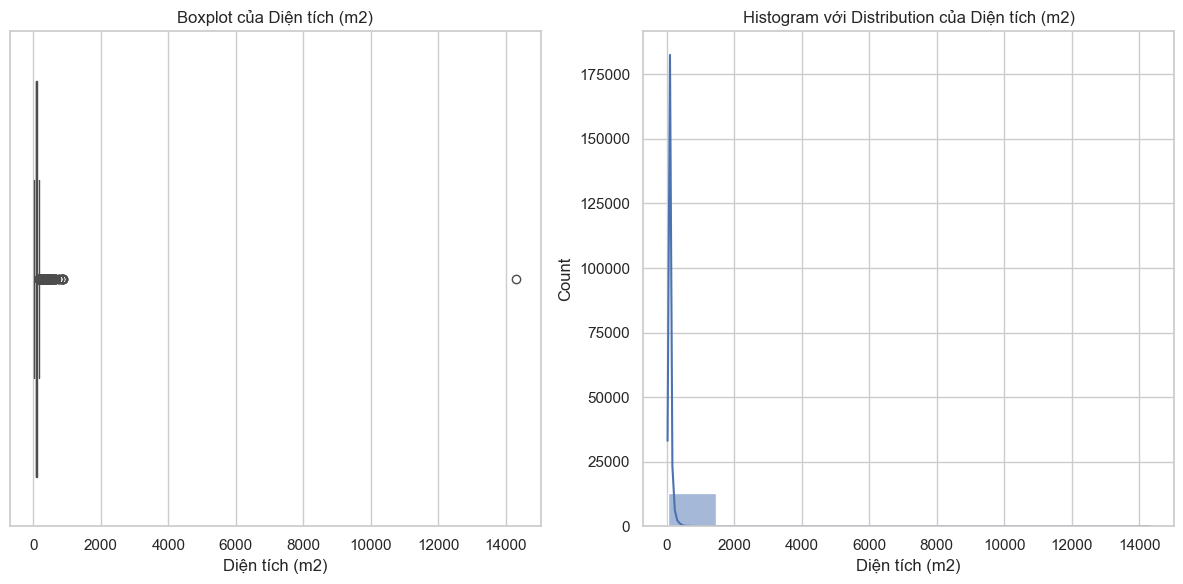

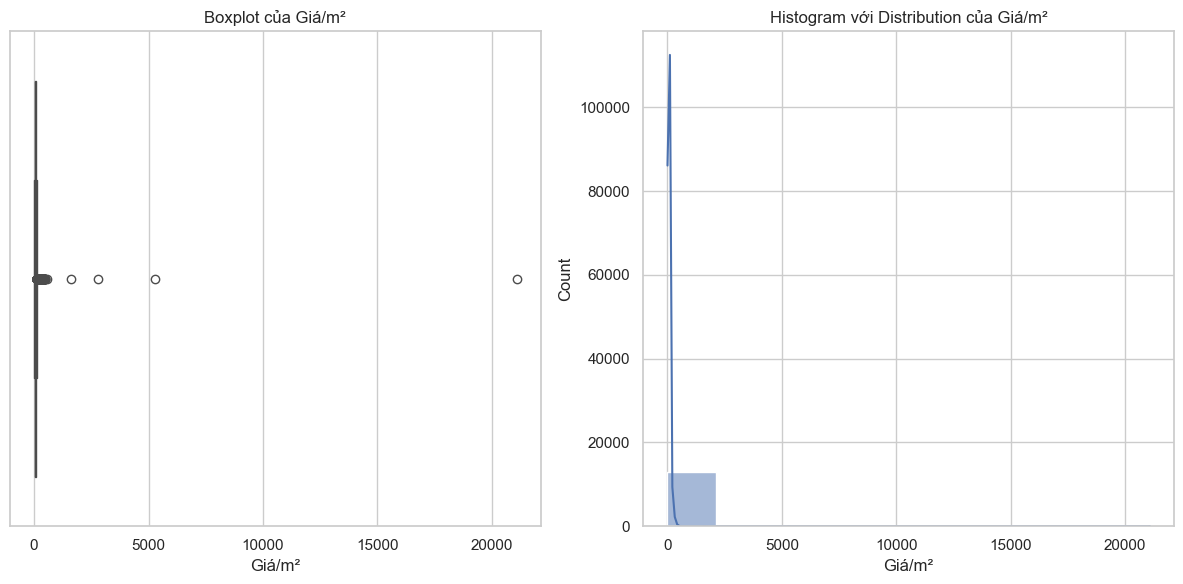

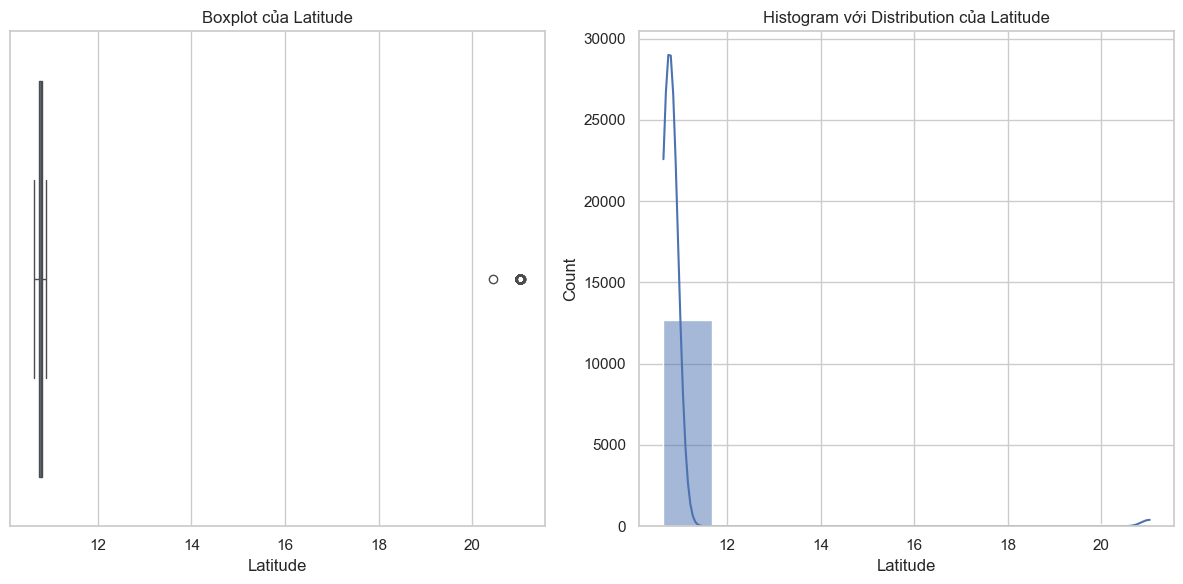

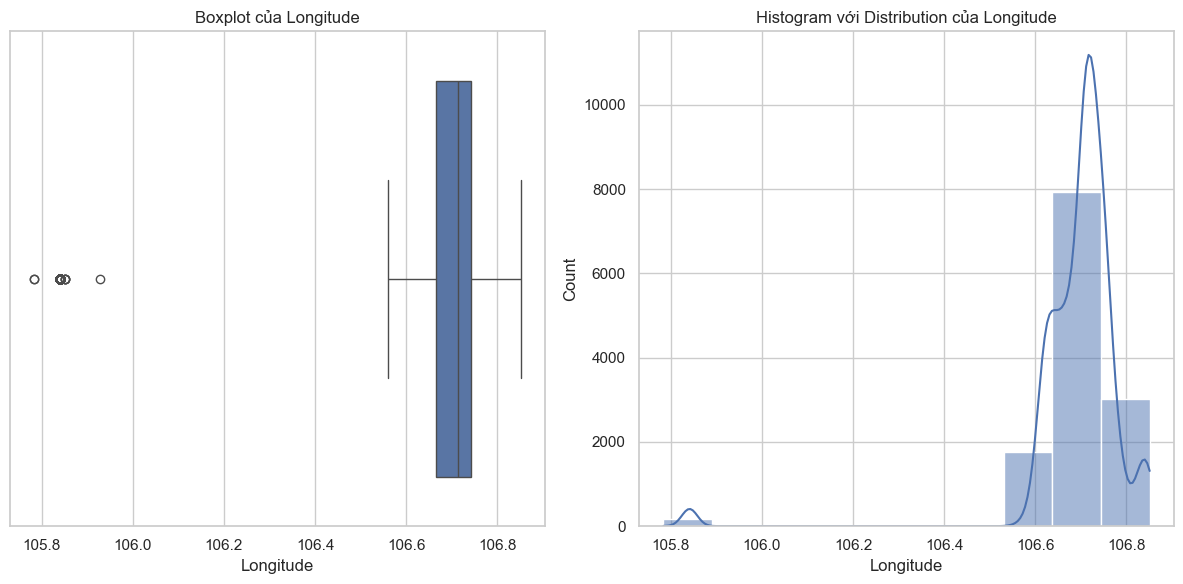

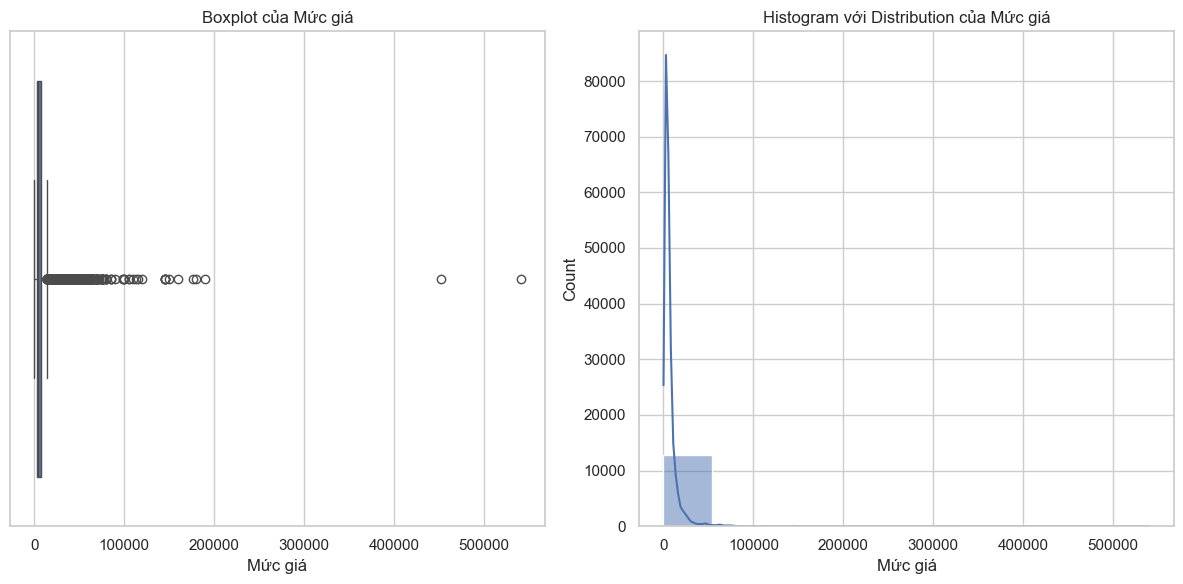

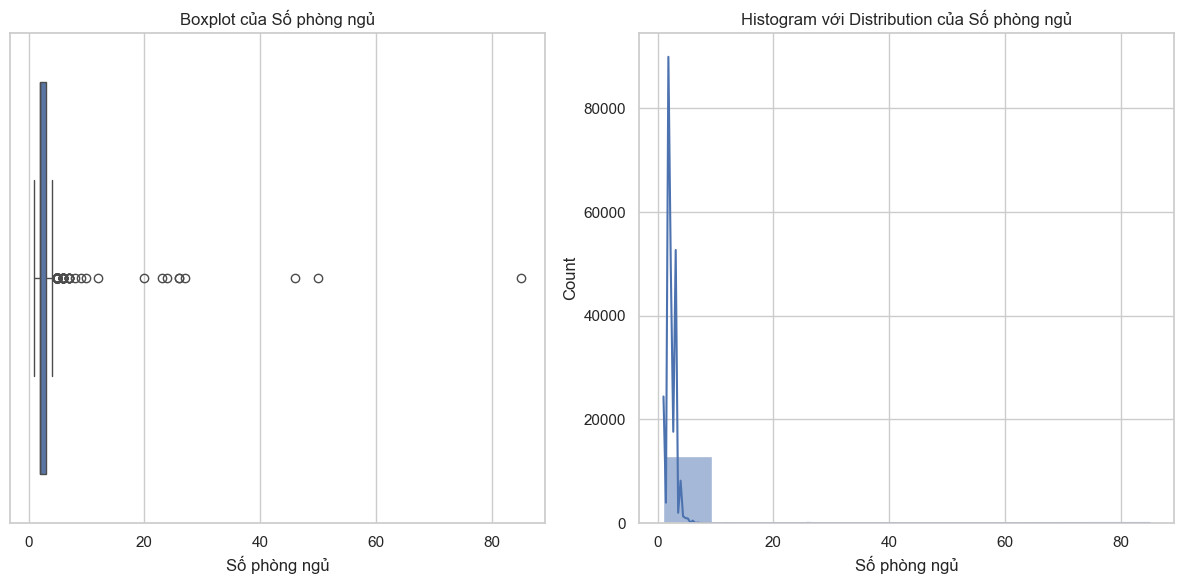

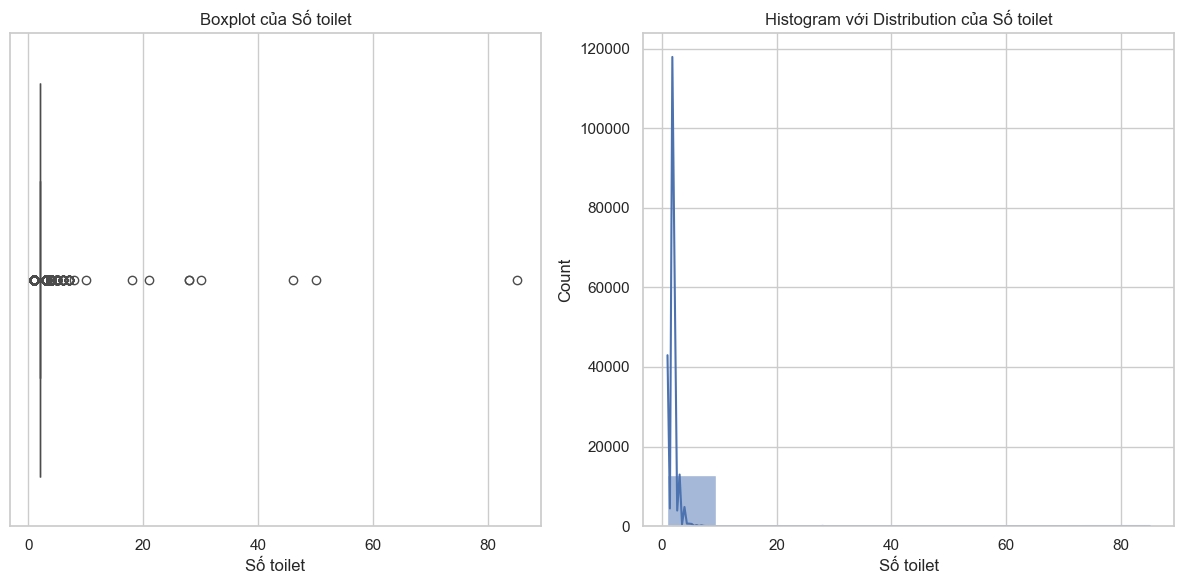

In [83]:
for feature in num_var:
  plot_box_hist(data_imp_xgboost, feature)

In [87]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def detect_outliers_dbscan(df, eps=0.5, min_samples=5):
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_data)
    labels = dbscan.labels_
    df['DBSCAN Label'] = labels
    outliers = df[df['DBSCAN Label'] == -1].reset_index(drop=True) 
    return outliers
outliers_dbscan = detect_outliers_dbscan(data_imp_xgboost, eps=0.5, min_samples=5) 

In [88]:
final_data = data_imp_xgboost.merge(outliers_dbscan, how='left', indicator=True)
final_data = final_data[final_data['_merge'] == 'left_only']

final_data = final_data.drop(columns='_merge')

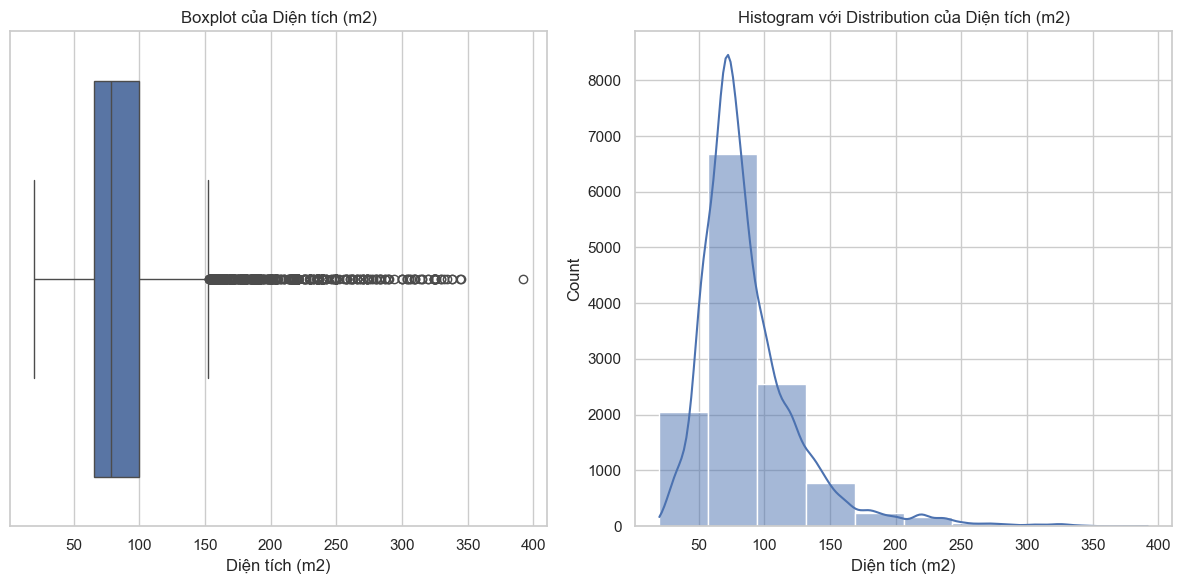

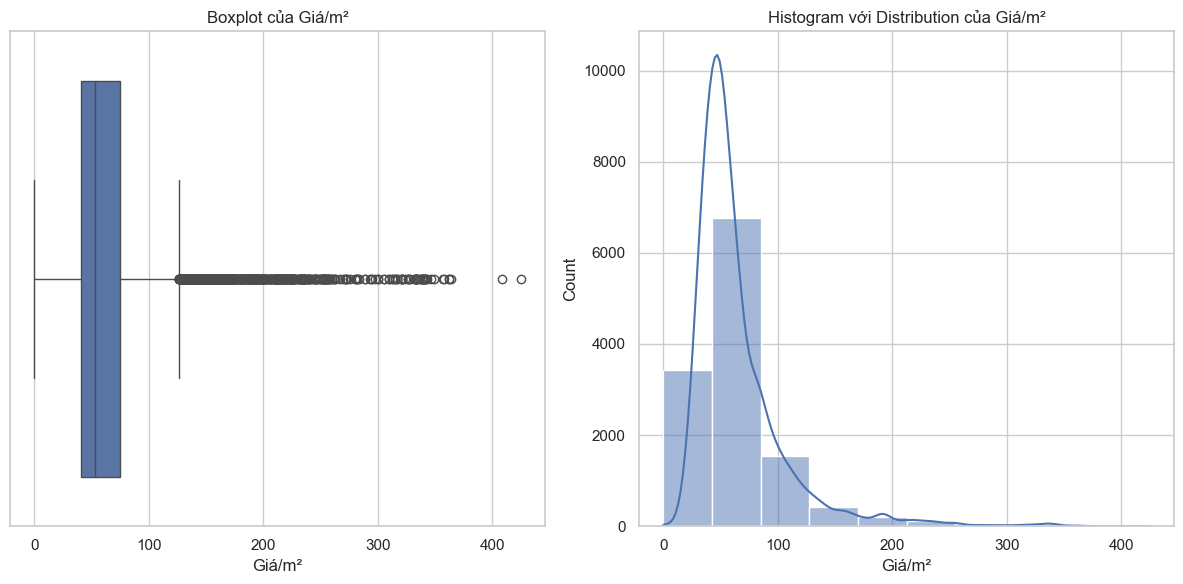

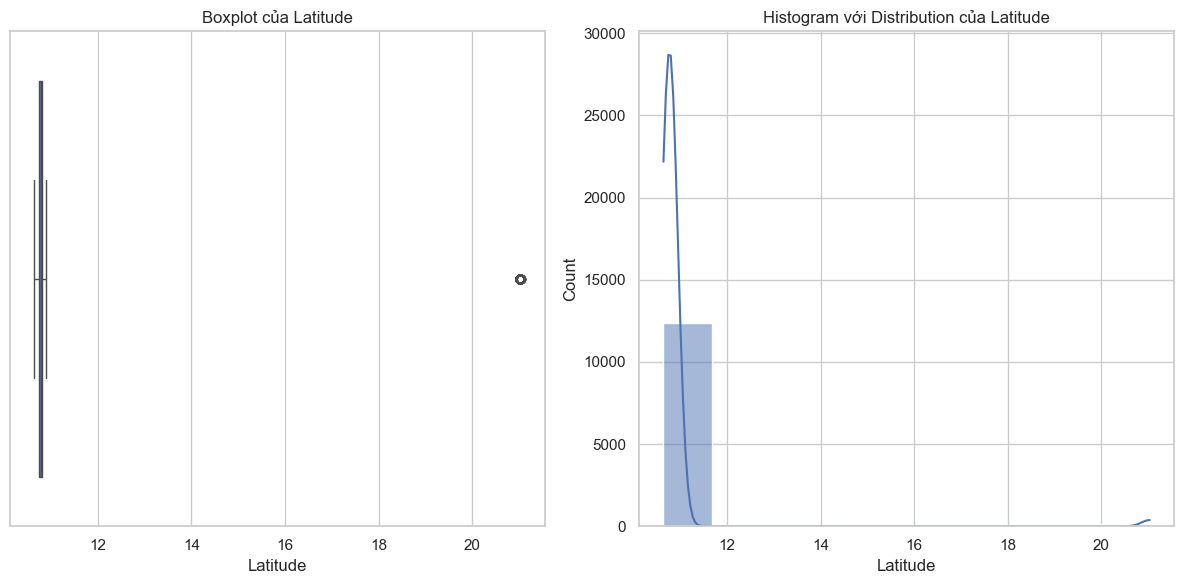

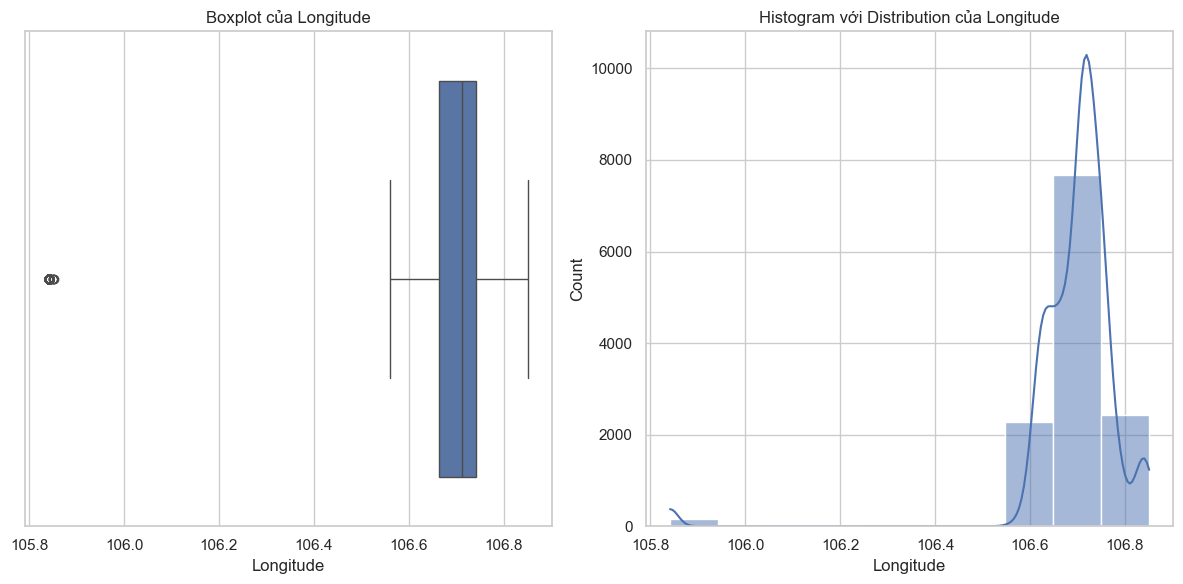

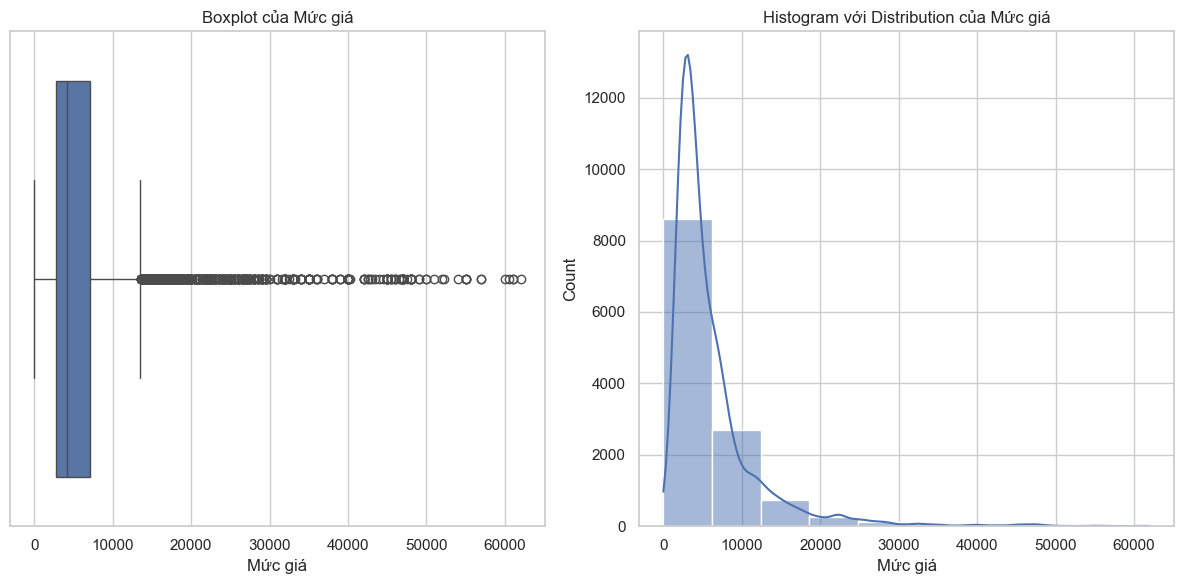

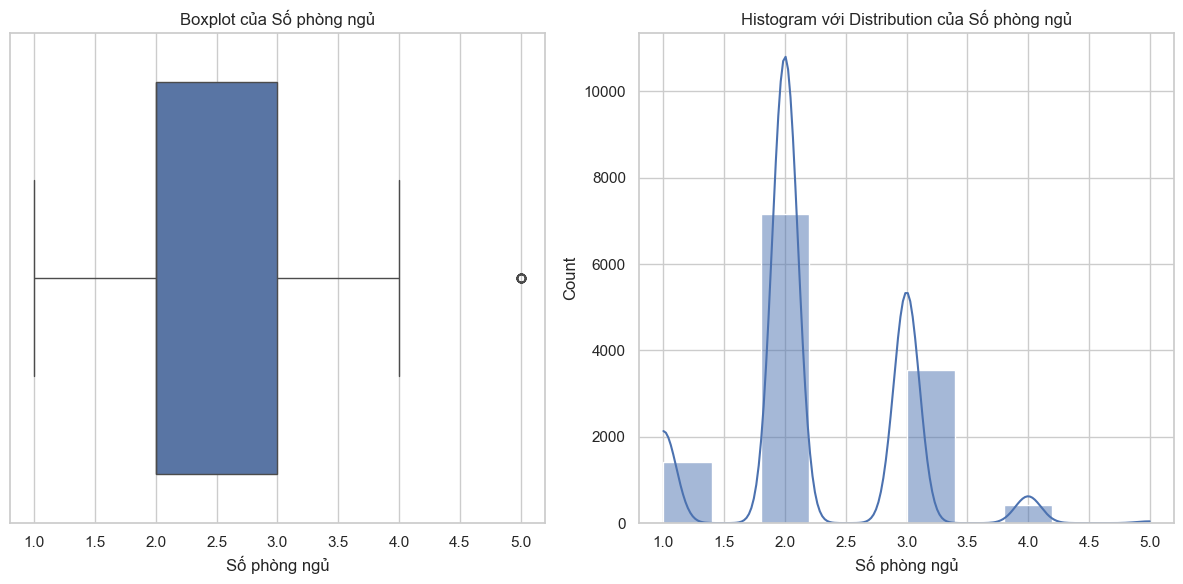

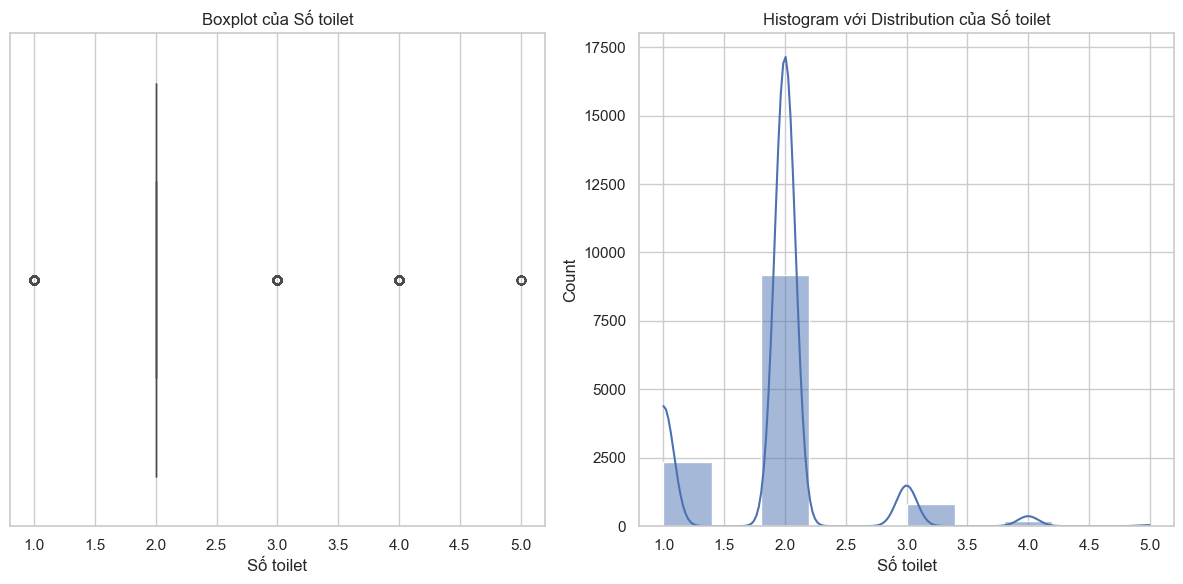

In [89]:
for feature in num_var:
  plot_box_hist(final_data, feature)

In [91]:
final_data.describe()

,Mức giá,Giá/m²,Số phòng ngủ,Diện tích (m2),Số toilet,Latitude,Longitude,DBSCAN Label
count,12550.000000,12550.000000,12550.000000,12550.000000,12550.000000,12550.000000,12550.000000,12550.000000
mean,6150.869602,65.138746,2.241833,87.344070,1.911713,10.900811,106.697169,1.921992
std,6009.881709,40.942154,0.697607,38.389991,0.564028,1.136849,0.111169,3.578794
min,3.480000,0.038670,1.000000,20.000000,1.000000,10.643736,105.841194,0.000000
25%,2800.000000,41.180000,2.000000,65.000000,2.000000,10.733747,106.664391,0.000000
50%,4200.000000,53.330000,2.000000,78.000000,2.000000,10.777396,106.712654,1.000000
75%,7105.193848,75.202500,3.000000,100.000000,2.000000,10.802690,106.741814,2.000000
max,62000.000000,424.849518,5.000000,392.000000,5.000000,21.029581,106.851036,30.000000


In [92]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12550 entries, 0 to 12879
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Địa chỉ         12550 non-null  object 
 1   Mức giá         12550 non-null  float64
 2   Giá/m²          12550 non-null  float64
 3   Số phòng ngủ    12550 non-null  int64  
 4   Huyện           12550 non-null  object 
 5   Diện tích (m2)  12550 non-null  float64
 6   Số toilet       12550 non-null  int64  
 7   Nội thất        12550 non-null  object 
 8   Latitude        12550 non-null  float64
 9   Longitude       12550 non-null  float64
 10  Đường           12550 non-null  object 
 11  DBSCAN Label    12550 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 1.2+ MB


In [93]:
final_data = final_data.drop(columns="DBSCAN Label")

In [95]:
final_data.to_csv("/Users/phongminh/DS105/final/final_data.csv")